In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [2]:
REGIONS   = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Kotkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
FILEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data'
SAVEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
CASES   = [(6,'June','#D42028'),(7,'July','#F2C85E'),(8,'August','#5BA7DA')]
SAMPLETHRESH = 50

In [3]:
def open_dataset(filename,multi=False,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    if multi==True:
        ds = xr.open_mfdataset(filepath)
    else:
        ds = xr.open_dataset(filepath)
    return ds

data = open_dataset('processed/binned_stats_new.nc')

In [4]:
def get_bin_mean_pr(stats,bintype,samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        Q0 = stats.Q0.values
        Q1 = stats.Q1.values
        Q0[Q0==0.0] = np.nan
        Q = Q1/Q0
        Q[Q0<samplethresh] = np.nan
        return Q
    if bintype=='2D':
        P0 = stats.P0.values
        P1 = stats.P1.values
        P0[P0==0.0] = np.nan
        P = P1/P0
        P[P0<samplethresh] = np.nan
        return P

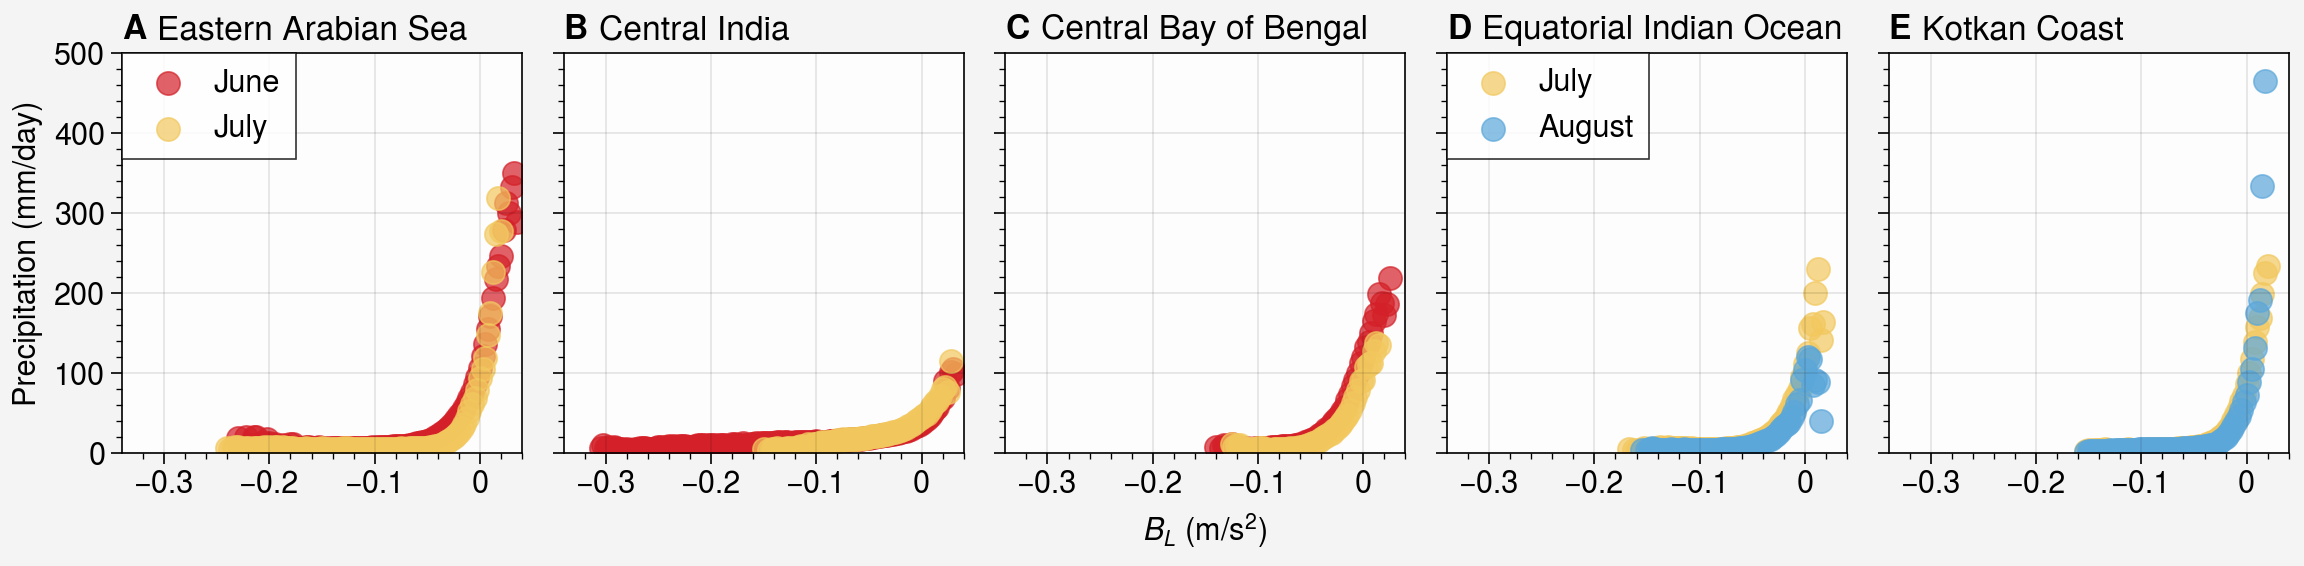

In [27]:
pplt.rc['fontsize'] = 11
CASES1 = [(6,'June','#D42028'),(7,'July','#F2C85E')]
CASES2 = [(7,'July','#F2C85E'),(8,'August','#5BA7DA')]
fig,axs = pplt.subplots(nrows=1,ncols=5,refwidth=2)
axs.format(abc='A',abcloc='l',titleloc='l',facecolor='pale gray',xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.34,0.04),xticks=0.1,
           ylabel='Precipitation (mm/day)',ylim=(0,500),yticks=100)
axs[0].format(title='Eastern Arabian Sea')
axs[1].format(title='Central India')
axs[2].format(title='Central Bay of Bengal')
axs[3].format(title='Equatorial Indian Ocean')
axs[4].format(title='Kotkan Coast')

for i,region in enumerate(data.region.values[:3]):
    regiondata = data.sel(region=region)
    for month,label,color in CASES1:
        monthdata = regiondata.sel(month=month)
        x = monthdata.bl.values
        y = get_bin_mean_pr(monthdata,bintype='1D')
        axs[i].scatter(x,y,color=color,alpha=0.7,s=70,label=label)
axs[0].legend(loc='ul',ncols=1)

for i,region in enumerate(data.region.values[3:]):
    regiondata = data.sel(region=region)
    for month,label,color in CASES2:
        monthdata = regiondata.sel(month=month)
        x = monthdata.bl.values
        y = get_bin_mean_pr(monthdata,bintype='1D')
        axs[i+3].scatter(x,y,color=color,alpha=0.7,s=70,label=label)
axs[3].legend(loc='ul',ncols=1)

pplt.show()
# fig.save(f'{SAVEDIR}/fig_2_poster.png',facecolor='#EEF7FC',dpi=900)

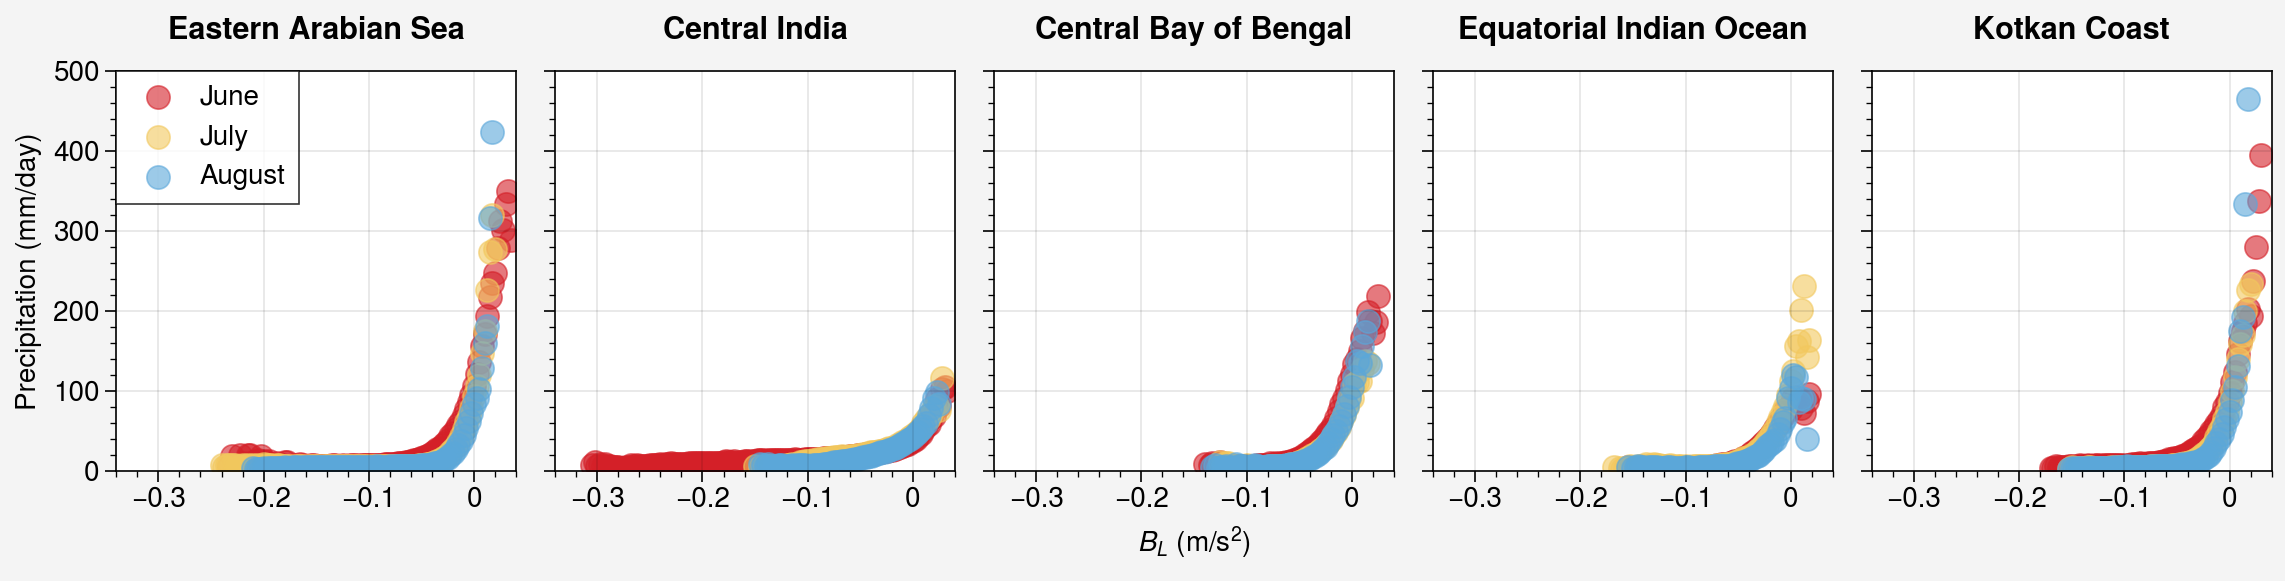

In [14]:
fig,axs = pplt.subplots(nrows=1,ncols=len(REGIONS.keys()),share=True,refwidth=2)
axs.format(collabels=REGIONS.keys(),xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.3401,0.04),xticks=0.1,
           ylabel='Precipitation (mm/day)',yticks=100,ylim=(0,500))

for i,region in enumerate(data.region.values):
    regiondata = data.sel(region=region)
    for month,label,color in CASES:
        monthdata = regiondata.sel(month=month)
        x = monthdata.bl.values
        y = get_bin_mean_pr(monthdata,bintype='1D')
        axs[i].scatter(x,y,color=color,alpha=0.6,s=70,label=label)
axs[0].legend(loc='ul',ncols=1)

pplt.show()
# fig.save(f'{SAVEDIR}/fig_2.png',dpi=300)